In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import soundfile
from IPython.display import Audio
import os
import torchaudio


%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

mps


In [46]:
def get_and_load_audio(path, length=5):
  if (not os.path.exists(path)):
    !wget https://www.vincentsitzmann.com/siren/img/audio/gt_bach.wav
  else:
    print('File already exists')
    
  # audio is a tensor of shape (num_channels, num_samples)
  # sampling_rate = number of samples / total time taken
  audio, sampling_rate = torchaudio.load(path)
  
  # trim the audio to the first 5 seconds
  soundfile.write(path, soundfile.read(path, stop=length * sampling_rate)[0], sampling_rate)
  
  return audio, sampling_rate

In [50]:
path = './gt_bach.wav'
audio, sampling_rate = get_and_load_audio(path)
print("Sampling rate:", sampling_rate)
print("Audio length:", audio.shape[1] / sampling_rate, "seconds")
Audio(path)
audio = audio[0]

File already exists
Sampling rate: 44100
Audio length: 5.0 seconds


In [62]:
def plot_audio(audio_tensor, sampling_rate, color, title=""):
  plt.figure(figsize=(15, 4))
  plt.plot(audio_tensor, color=color, alpha=0.7)
  plt.xticks(np.arange(0, audio_tensor.shape[0], sampling_rate), np.arange(0, audio_tensor.shape[0] / sampling_rate, 1))
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title(title)
  plt.grid()
  plt.show()

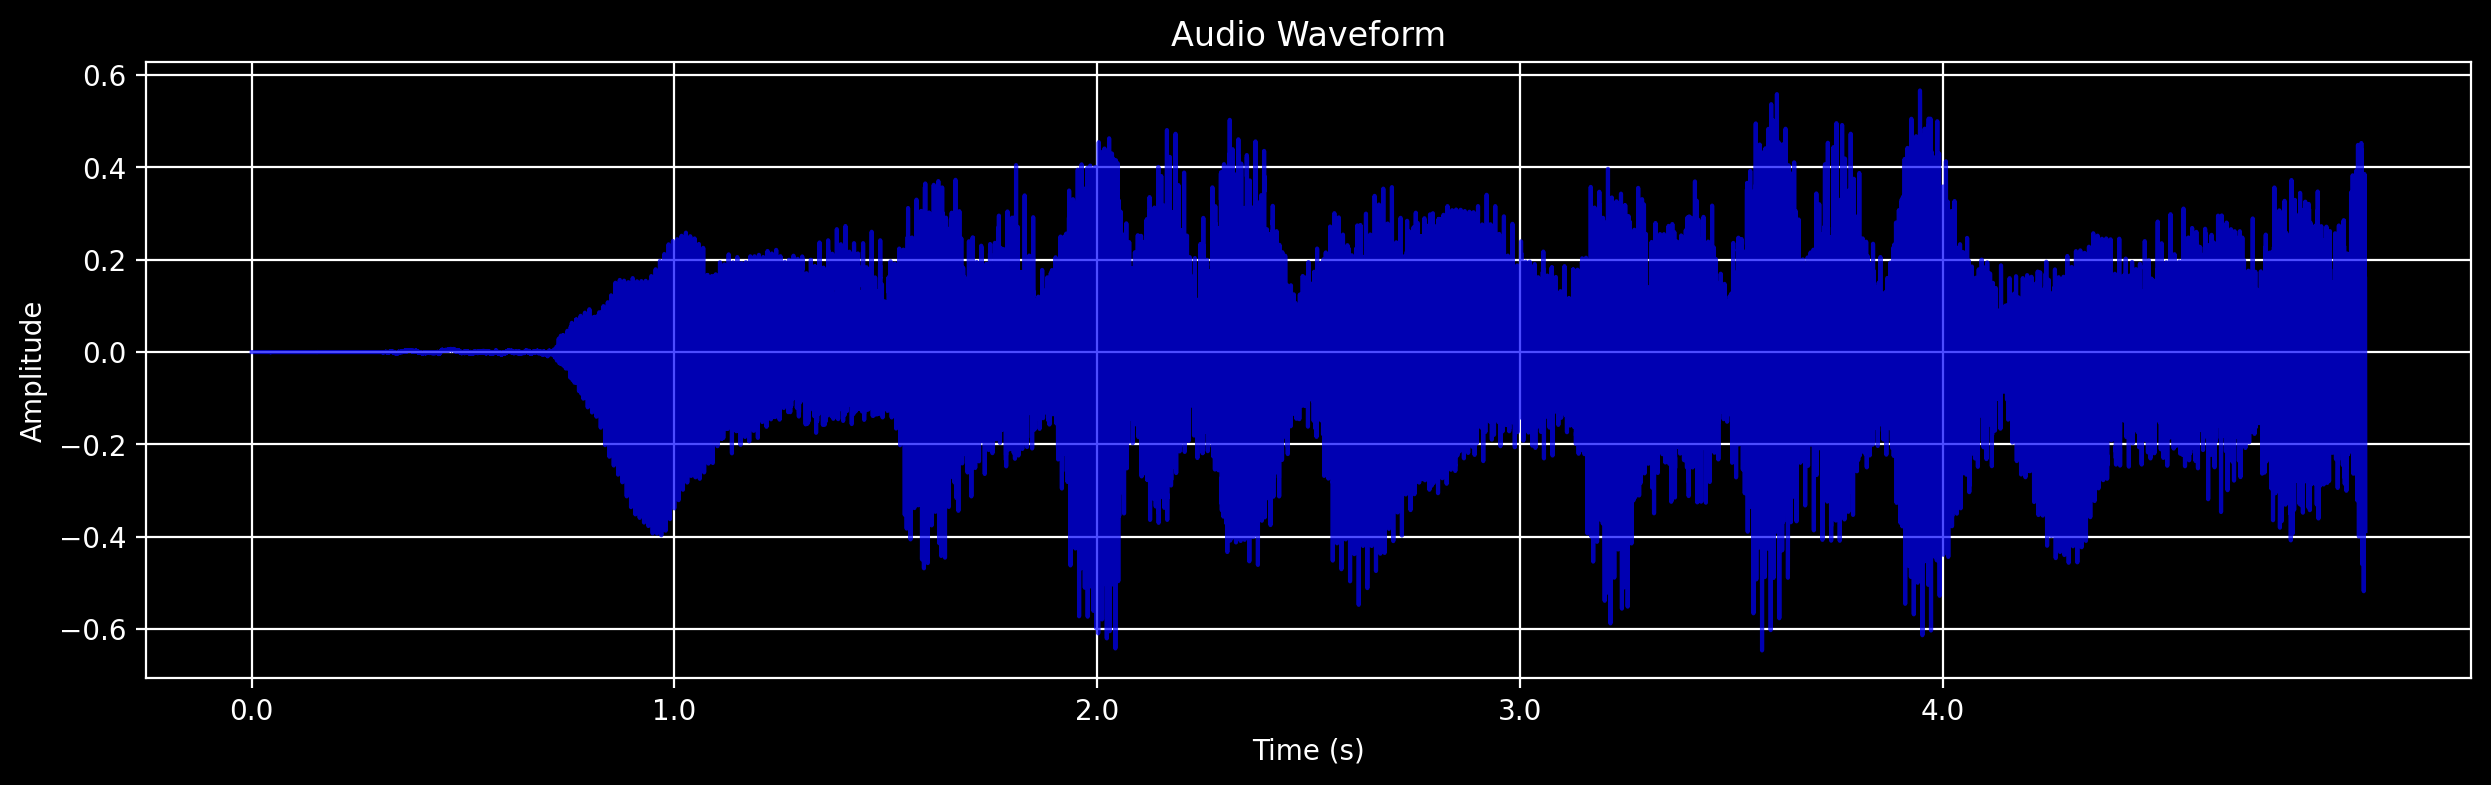

In [63]:
plot_audio(audio, sampling_rate, 'blue', 'Audio Waveform')

In [74]:
# here we are creating a tensor of shape (num_samples, 1) where each value is the time in seconds
# creating it from 0 to len(audio) and then normalizing it to be between -100 and 100
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 2 - 1
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-1.0000],
        [-1.0000],
        [-1.0000],
        ...,
        [ 1.0000],
        [ 1.0000],
        [ 1.0000]])


In [75]:
Audio(audio, rate=sampling_rate)

In [76]:
from sklearn.kernel_approximation import RBFSampler


def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components=num_features, gamma=1 /
                     (2 * sigma**2), random_state=13)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)

In [77]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 5000])
tensor([[-0.0014,  0.0200,  0.0061,  ...,  0.0168, -0.0119,  0.0156],
        [-0.0014,  0.0200,  0.0061,  ...,  0.0168, -0.0119,  0.0156],
        [-0.0014,  0.0200,  0.0061,  ...,  0.0168, -0.0119,  0.0156],
        ...,
        [-0.0157,  0.0200,  0.0197,  ..., -0.0130,  0.0049,  0.0041],
        [-0.0157,  0.0200,  0.0197,  ..., -0.0130,  0.0049,  0.0041],
        [-0.0157,  0.0200,  0.0197,  ..., -0.0130,  0.0049,  0.0042]])


In [78]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [79]:
import soundfile as sf
import joblib
joblib.dump(model, 'model.pkl')
model = joblib.load('model.pkl')

sf.write('pred_audio.wav', pred_audio, sampling_rate)

In [80]:
Audio(pred_audio, rate=sampling_rate)